<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/InfoDengue_vs_Clade_MG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install geobr
!pip install unidecode
!pip install rapidfuzz

In [5]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import requests
import plotly.graph_objects as go

import time
from tqdm import tqdm

from geobr import read_municipality, read_state
import geopandas as gpd
import gc

from statsmodels.tsa.stattools import ccf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from statsmodels.gam.api import GLMGam, BSplines

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from unidecode import unidecode

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score

import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Clade Data

In [10]:
path = r"/content/drive/MyDrive/GISAID/nextclade_mg_all.xlsx"

frames = []
xls = pd.ExcelFile(path)
for sh in xls.sheet_names:
    df = pd.read_excel(path, sheet_name=sh, dtype=str)
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
    df['sheet'] = sh
    frames.append(df)

clade_data = pd.concat(frames, ignore_index=True, sort=False)
clade_data.head()

,index,seqName,clade,qc.overallScore,qc.overallStatus,totalSubstitutions,totalDeletions,totalInsertions,totalFrameShifts,totalMissing,...,qc.stopCodons.stopCodons,qc.stopCodons.totalStopCodons,qc.stopCodons.score,qc.stopCodons.status,totalPcrPrimerChanges,pcrPrimerChanges,failedCdses,warnings,errors,sheet
0,2,hDenV1/Brazil/MG-IAL-357148588/2023|EPI_ISL_18...,1V_E.1,0,good,853,0,0,0,0,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
1,3,hDenV1/Brazil/MG-LACENMG-311258475/2022|EPI_IS...,1V_E.1,3.168400,good,799,0,0,0,278,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
2,4,hDenV1/Brazil/MG-LACENMG-311240155/2022|EPI_IS...,1V_F,1.303143,good,791,0,0,0,214,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
3,5,hDenV1/Brazil/MG-LACENMG-311240059/2022|EPI_IS...,1V_E.1,0.096100,good,818,0,0,0,131,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
4,6,hDenV1/Brazil/MG-LACENMG-311378222/2023|EPI_IS...,1V_E.1,0.008100,good,820,0,0,0,109,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1


In [11]:
clade_data2 = clade_data[['seqName','clade']].copy()
clade_data2['Virus name'] = clade_data2['seqName'].str.split('|EPI_', n=1, regex=False).str[0]
clade_data2

,seqName,clade,Virus name
0,hDenV1/Brazil/MG-IAL-357148588/2023|EPI_ISL_18...,1V_E.1,hDenV1/Brazil/MG-IAL-357148588/2023
1,hDenV1/Brazil/MG-LACENMG-311258475/2022|EPI_IS...,1V_E.1,hDenV1/Brazil/MG-LACENMG-311258475/2022
2,hDenV1/Brazil/MG-LACENMG-311240155/2022|EPI_IS...,1V_F,hDenV1/Brazil/MG-LACENMG-311240155/2022
3,hDenV1/Brazil/MG-LACENMG-311240059/2022|EPI_IS...,1V_E.1,hDenV1/Brazil/MG-LACENMG-311240059/2022
4,hDenV1/Brazil/MG-LACENMG-311378222/2023|EPI_IS...,1V_E.1,hDenV1/Brazil/MG-LACENMG-311378222/2023
...,...,...,...
1037,hDenV4/Brazil/MG-LACENMG-312299595/2025|EPI_IS...,4II_B.1.3,hDenV4/Brazil/MG-LACENMG-312299595/2025
1038,hDenV4/Brazil/MG-LACENMG-312457087/2025|EPI_IS...,4II_B.1.3,hDenV4/Brazil/MG-LACENMG-312457087/2025
1039,hDenV4/Brazil/MG-FUNED-311741779/2024|EPI_ISL_...,4II_B,hDenV4/Brazil/MG-FUNED-311741779/2024
1040,hDenV4/Brazil/MG-LACENMG-312301309/2025|EPI_IS...,4II_B,hDenV4/Brazil/MG-LACENMG-312301309/2025


## GISAID Data

In [39]:
sero_all = pd.read_csv('/content/drive/MyDrive/GISAID/gisaid_arbo_2025_10_06_06_mg.tsv', sep='\t')
location_split = sero_all['Location'].str.split(' / ', expand=True)
location_split.columns = ['Continent', 'Country', 'State', 'City']
sero_all = pd.concat([sero_all, location_split], axis=1)

sero_all = sero_all[['Virus name', 'Serotype', 'Genotype','Collection date', 'City']]

sero_all['ym'] = pd.to_datetime(sero_all['Collection date'], errors='coerce').dt.strftime('%Y-%m')
sero_all.head(3)

/tmp/ipython-input-3483771818.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sero_all['ym'] = pd.to_datetime(sero_all['Collection date'], errors='coerce').dt.strftime('%Y-%m')


,Virus name,Serotype,Genotype,Collection date,City,ym
0,DenV3/un/Brazil/MG-UFMG-24/un,DENV3,V,unknown,None,NaN
1,DenV3/un/Brazil/MG-UFMG-20/un,DENV3,V,unknown,None,NaN
2,hDenV1/Brazil/MG-IAL-357148588/2023,DENV1,V,2023-05-11,Pocos De Caldas,2023-05


In [40]:
# Check Nan
sero_all.isna().sum()

,0
Virus name,0
Serotype,0
Genotype,0
Collection date,0
City,408
ym,2


In [41]:
# Rename city with NaN as no-name
# sero_all['City'] = sero_all['City'].fillna("no-name")
sero_all = sero_all.dropna(subset=['City'])
# Check the data without date
sero_all[sero_all['ym'].isna()]

,Virus name,Serotype,Genotype,Collection date,City,ym


In [42]:
# Drop information without month data and unknown (because aggregate data to yearly is too coarse)
sero_all = sero_all.dropna(subset=['ym'])
sero_all[sero_all['ym'].isna()]

,Virus name,Serotype,Genotype,Collection date,City,ym


In [43]:
print("the data starts from",sero_all['ym'].min(), 'to', sero_all['ym'].max())

the data starts from 2022-02 to 2025-05


In [44]:
sero_all.head(5)

,Virus name,Serotype,Genotype,Collection date,City,ym
2,hDenV1/Brazil/MG-IAL-357148588/2023,DENV1,V,2023-05-11,Pocos De Caldas,2023-05
3,hDenV1/Brazil/MG-IAL-357199033/2023,DENV1,V,2023-06-19,Sao Goncalo Do Sapucai,2023-06
4,hDenV3/Brazil/MG-FED-311641591/2023,DENV3,III,2023-11-21,Belo Horizonte,2023-11
5,hDenV2/Brazil/MG-un-86/2022,DENV2,II,2022-05-07,Conselheiro Lafaiete,2022-05
6,hDenV2/Brazil/MG-un-82/2022,DENV2,II,2022-06-03,Juiz de Fora,2022-06


## Merge Clade and GISAID

In [45]:
sero1 = pd.merge(clade_data2[['Virus name', 'clade']], sero_all, on=["Virus name"], how="right")
sero1.head(5)

,Virus name,clade,Serotype,Genotype,Collection date,City,ym
0,hDenV1/Brazil/MG-IAL-357148588/2023,1V_E.1,DENV1,V,2023-05-11,Pocos De Caldas,2023-05
1,hDenV1/Brazil/MG-IAL-357199033/2023,1V_E.1,DENV1,V,2023-06-19,Sao Goncalo Do Sapucai,2023-06
2,hDenV3/Brazil/MG-FED-311641591/2023,3III_B.3.2,DENV3,III,2023-11-21,Belo Horizonte,2023-11
3,hDenV2/Brazil/MG-un-86/2022,2II_F.1.1.2,DENV2,II,2022-05-07,Conselheiro Lafaiete,2022-05
4,hDenV2/Brazil/MG-un-82/2022,2II_F.1.1.2,DENV2,II,2022-06-03,Juiz de Fora,2022-06


In [46]:
sero1.isna().sum()

,0
Virus name,0
clade,0
Serotype,0
Genotype,0
Collection date,0
City,0
ym,0


In [47]:
sero1['clade'].unique()

array(['1V_E.1', '3III_B.3.2', '2II_F.1.1.2', '1V_D.1.1', '1V_F', '1V_A',
       '1V_E', '4II_B.1.3', '2V', '4II_B'], dtype=object)

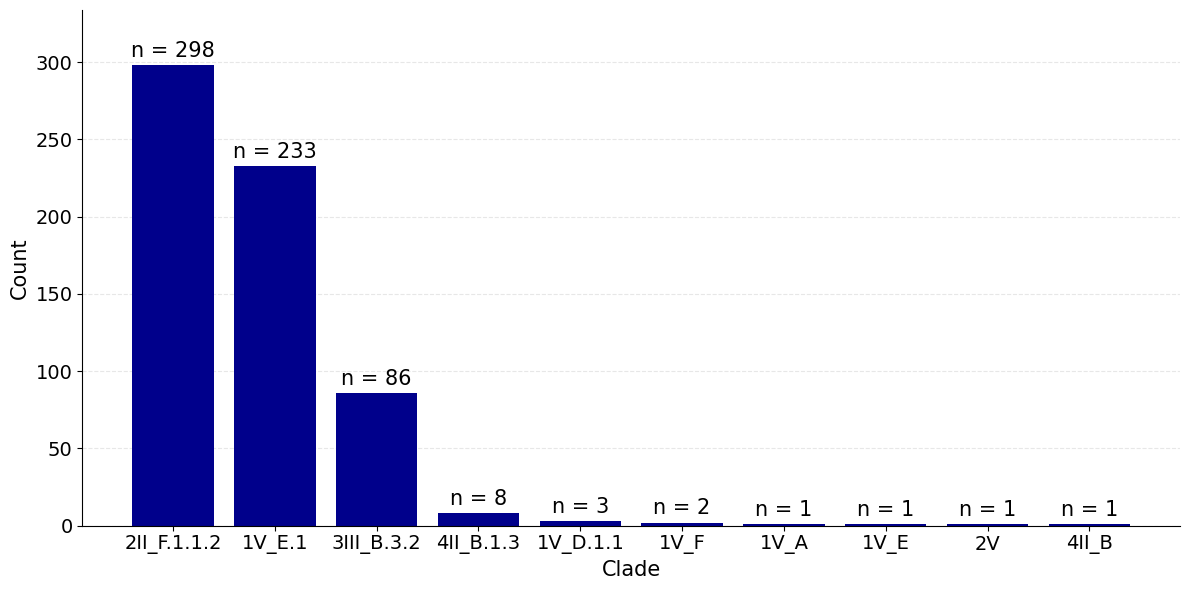

In [60]:
clade_counts = (sero1.groupby('clade')
                  .size()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())


w = max(12, 0.7 * len(clade_counts))
fig, ax = plt.subplots(figsize=(w, 6))

bars = ax.bar(clade_counts['clade'], clade_counts['count'], color='darkblue')

ax.bar_label(bars,labels=[f"n = {v:,}" for v in clade_counts['count']],padding=3, fontsize=15)

# ax.set_title("Clade Counts – Sao Paulo", fontsize=14, weight='bold', name='Liberation Mono')
ax.set_xlabel('Clade', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', rotation=0, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.margins(y=0.12)
plt.tight_layout()
plt.show()


## Get IBGE

In [61]:
def norm_name(s):
    s = str(s).strip().lower()
    s = s.replace("''", "'")
    s = s.replace(" d'oeste", " do oeste")
    s = unidecode(s)
    for ch in "-'.,":
        s = s.replace(ch, ' ')
    return ' '.join(s.split())

In [62]:
# Extra MG
extra = {
    "ribeir o das neves": "ribeirao das neves",
    "coromande": "coromandel",
    "sao franscisco de sales": "sao francisco de sales",
    "sao joao del rei": "sao joao del rei",
    "para de minas": "para de minas",
    "limeira do oeste": "limeira do oeste",
    "uniao de minas": "uniao de minas",
    "sao jose da lapa": "sao jose da lapa",
    "santo antonio do aventureiro": "santo antonio do aventureiro",
    "santa rita do sapucai": "santa rita do sapucai",
    "no-name": "",
    "pendente": "",
}

In [63]:
def attach_ibge(sero_df, ref_df, city_col="City", out_col="IBGE"):

    ref_df = ref_df.copy()
    ref_df = ref_df.rename(columns=str.lower)
    ref_df["name_key"] = ref_df["name"].apply(norm_name)

    sero_df = sero_df.copy()
    sero_df["_city_norm"] = sero_df[city_col].astype(str).apply(norm_name)
    sero_df["_city_key"]  = sero_df["_city_norm"].map(extra).fillna(sero_df["_city_norm"])

    merged = sero_df.merge(ref_df[["name_key", "ibge_code", "name"]], left_on="_city_key", right_on="name_key", how="left")

    merged[out_col] = merged["ibge_code"]
    merged = merged.drop(columns=["_city_norm", "_city_key", "name_key", "ibge_code"])

    return merged

In [64]:
# take ibge data
mun = read_municipality(year=2020)
mun_mg = mun[mun['code_state'] == 31].copy()

ref_mg = (mun_mg[['name_muni','code_muni']].drop_duplicates()
            .rename(columns={'name_muni':'name','code_muni':'ibge_code'}))
ref_mg['ibge_code'] = ref_mg['ibge_code'].astype('Int64')
ref_mg.head()

,name,ibge_code
2244,Abadia Dos Dourados,3100104
2245,Abaeté,3100203
2246,Abre Campo,3100302
2247,Acaiaca,3100401
2248,Açucena,3100500


In [65]:
sero1_ibge = attach_ibge(sero1, ref_mg)
sero1_ibge.loc[sero1_ibge['City'] == 'Dona Eusebia', 'name'] = 'Dona Euzébia'
sero1_ibge.loc[sero1_ibge['City'] == 'Dona Eusebia', 'IBGE'] = 3122900

In [66]:
# Check the city that has no ibge
sero1_ibge[(sero1_ibge['City'] != 'no-name') & (sero1_ibge['IBGE'].isna())]

,Virus name,clade,Serotype,Genotype,Collection date,City,ym,name,IBGE
19,hDenV1/Brazil/MG-ITpS-18437/2023,1V_E.1,DENV1,V,2023-04-28,Nova Veneza,2023-04,NaN,<NA>
177,hDenV1/Brazil/MG-ITpS-20232/2023,1V_E.1,DENV1,V,2023-03-20,Pendente,2023-03,NaN,<NA>
210,hDenV1/Brazil/MG-ITpS-20220/2023,1V_E.1,DENV1,V,2023-03-20,Pendente,2023-03,NaN,<NA>
219,hDenV1/Brazil/MG-ITpS-20254/2023,1V_E.1,DENV1,V,2023-03-27,Pendente,2023-03,NaN,<NA>


In [67]:
sero1_ibge.head(3)

,Virus name,clade,Serotype,Genotype,Collection date,City,ym,name,IBGE
0,hDenV1/Brazil/MG-IAL-357148588/2023,1V_E.1,DENV1,V,2023-05-11,Pocos De Caldas,2023-05,Poços De Caldas,3151800
1,hDenV1/Brazil/MG-IAL-357199033/2023,1V_E.1,DENV1,V,2023-06-19,Sao Goncalo Do Sapucai,2023-06,São Gonçalo Do Sapucaí,3162005
2,hDenV3/Brazil/MG-FED-311641591/2023,3III_B.3.2,DENV3,III,2023-11-21,Belo Horizonte,2023-11,Belo Horizonte,3106200


In [68]:
# ## Take the ibge data of the GISAiD data and export
# gcode = sero1_ibge['IBGE'].dropna().unique()
# gcode_df = pd.DataFrame({'ibge': gcode})

# out_dir = "/content/drive/MyDrive/GISAID"
# out_path = f"{out_dir}/sp_gisaid_geocode.csv"
# gcode_df.to_csv(out_path, index=False)

In [ ]:
sero1_ibge.isna().sum() # 406 of it are "no-name" the other 4 bcs there is no matches in the ibge

,0
Virus name,0
clade,0
Serotype,0
Genotype,0
Collection date,0
City,0
ym,0
name,4
IBGE,4


Take the ibge data for MEM analysis

In [ ]:
saveibge = False
if saveibge:
  mg_ibge_code = sero1_ibge[['name', 'IBGE']].drop_duplicates()
  mg_ibge_code.dropna(inplace=True)


  out_dir = '/content/drive/MyDrive/GISAID'
  file_path = os.path.join(out_dir, 'mg_gisaid_geocode.csv')
  mg_ibge_code.to_csv(file_path, index=False)

  print("Saved done, to:", file_path)

## Import the MEM Results

In [ ]:
mem_res = pd.read_csv('/content/drive/MyDrive/GISAID/MEM_classification_MG.csv')
mem_res = mem_res[mem_res['data_iniSE'] >= '2022-01-01'] # Take only 2022 onwards to match the period of GISAID dataset
mem_res.head(5)

,data_iniSE,casos,pop,nivel,ibge,rate_pop,week,season,season_start,t_in_season,mem_status
596,2022-01-02,1,35401,1,3101508,2.824779,52,2022,2021-08-01,23,endemic
597,2022-01-09,0,35401,1,3101508,0.000000,1,2022,2021-08-01,24,endemic
598,2022-01-16,1,35401,1,3101508,2.824779,2,2022,2021-08-01,25,endemic
599,2022-01-23,0,35401,1,3101508,0.000000,3,2022,2021-08-01,26,endemic
600,2022-01-30,0,35401,1,3101508,0.000000,4,2022,2021-08-01,27,endemic


## Filter the GISAID Data Municipalities given the MEM data

In [ ]:
gcode_mem = mem_res["ibge"].astype(str).unique()
gcode_mem.dtype

dtype('O')

In [ ]:
sero1_ibge['IBGE'] = sero1_ibge['IBGE'].astype(str)
sero1_ibge = sero1_ibge[sero1_ibge['IBGE'].isin(gcode_mem)]

In [ ]:
len(sero1_ibge['IBGE'].unique())

77

In [ ]:
print("Check number of municipalities is correct:", len(gcode_mem) == len(sero1_ibge['IBGE'].unique()))

Check number of municipalities is correct: True


## Test weekly only for the whole state

In [ ]:
# sero_ibge_spt = sero1_ibge[sero1_ibge['IBGE'] == '3550308'].copy()
sero_ibge_spt = sero1_ibge.copy()
sero_ibge_spt["Collection date"] = pd.to_datetime(sero_ibge_spt["Collection date"])

sero_ibge_spt["week"] = (sero_ibge_spt["Collection date"].dt.to_period("W-SUN").dt.end_time.dt.normalize())

wide_week = (sero_ibge_spt.groupby(["week", "clade"])
             .size()
             .unstack(fill_value=0)
             .sort_index())

start = wide_week.index.min()
end   = wide_week.index.max()

full_weeks = pd.date_range(start=start, end=end, freq="W-SUN")  # now matches

wide_week_full = wide_week.reindex(full_weeks, fill_value=0).sort_index()
wide_week_full.index.name = "week"
wide_week_full

clade,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2II_F.1.1.2,3III_B.3.2,4II_B.1.3
week,,,,,,,,
2022-02-27,0,0,0,0,0,1,0,0
2022-03-06,0,0,0,0,0,0,0,0
2022-03-13,0,0,0,0,0,0,0,0
2022-03-20,0,0,0,0,0,0,0,0
2022-03-27,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2025-05-04,0,0,0,0,0,0,0,0
2025-05-11,0,0,0,0,0,0,0,0
2025-05-18,0,0,0,3,0,0,14,0


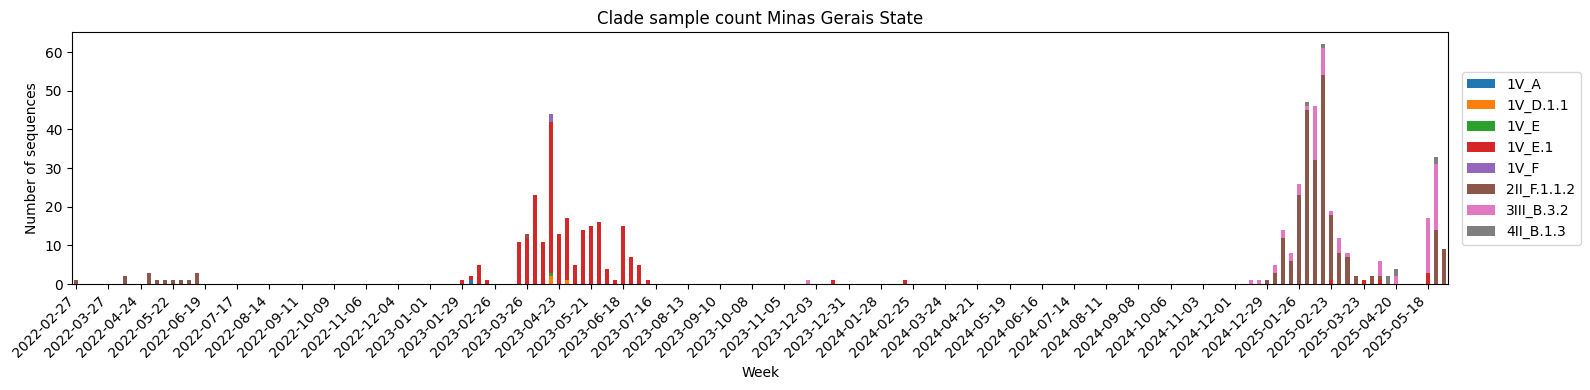

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
wide_week_full.plot(kind="bar", stacked=True, ax=ax)

ax.set_xlabel("Week")
ax.set_ylabel("Number of sequences")
ax.set_title("Clade sample count Minas Gerais State")

ax.set_xticks(range(0, len(wide_week_full), 4))
ax.set_xticklabels(
    wide_week_full.index[::4].strftime("%Y-%m-%d"),
    rotation=45, ha="right"
)

# put legend outside on the right
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,
          loc="center left",
          bbox_to_anchor=(1.01, 0.5),
          borderaxespad=0.)

plt.tight_layout()
plt.show()


## Aggregate all the Municipalities in the MEM Data

In [ ]:
wide_mem = (mem_res
    .groupby(["data_iniSE", "mem_status"])["rate_pop"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename_axis(None, axis=1)
)

wide_mem.head()

,data_iniSE,endemic,outbreak
0,2022-01-02,520.825244,50.109306
1,2022-01-09,494.163327,201.578392
2,2022-01-16,694.682432,220.742554
3,2022-01-23,364.145587,309.138338
4,2022-01-30,434.062866,443.864206


In [ ]:
def plot_clades_otb(
        wide_week_full,
        wide_mem,
        date_col="data_iniSE",
        value_col="outbreak",
        location_label="Sao Paulo State",
        figsize=(20, 5)
    ):

    # copy so we don't modify the originals
    ww = wide_week_full.copy()
    wm = wide_mem.copy()

    # ensure datetime alignment
    ww.index = pd.to_datetime(ww.index)
    wm[date_col] = pd.to_datetime(wm[date_col])

    # build outbreak time series aligned to clade weeks
    outbreak_ts = (
        wm
        .set_index(date_col)[value_col]
        .reindex(ww.index)
        .fillna(0)
    )

    # x positions used by bar plot
    x = np.arange(len(ww))

    fig, ax = plt.subplots(figsize=figsize)

    # stacked bars for clades
    ww.plot(kind="bar", stacked=True, ax=ax, alpha=0.7)

    ax.set_xlabel("Week")
    ax.set_ylabel("Number of sequences")
    ax.set_title(f"Clade and Outbreak Numbers {location_label}")

    # ticks: numeric positions, labels from dates
    ax.set_xticks(x[::4])
    ax.set_xticklabels(
        ww.index[::4].strftime("%Y-%m-%d"),
        rotation=45, ha="right"
    )

    # line on second y-axis
    ax2 = ax.twinx()
    line_label = value_col.replace("_", " ").title()
    line, = ax2.plot(
        x,
        outbreak_ts.values,
        linewidth=2,
        marker="o",
        markersize=3,
        label=line_label
    )
    ax2.set_ylabel("Number of outbreaks (aggregated)")

    # combine legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles = handles1 + [line]
    labels  = labels1 + [line_label]

    ax.legend(
        handles, labels,
        loc="center left",
        bbox_to_anchor=(1.06, 0.5),
        borderaxespad=0.,
    )

    plt.tight_layout()
    plt.show()


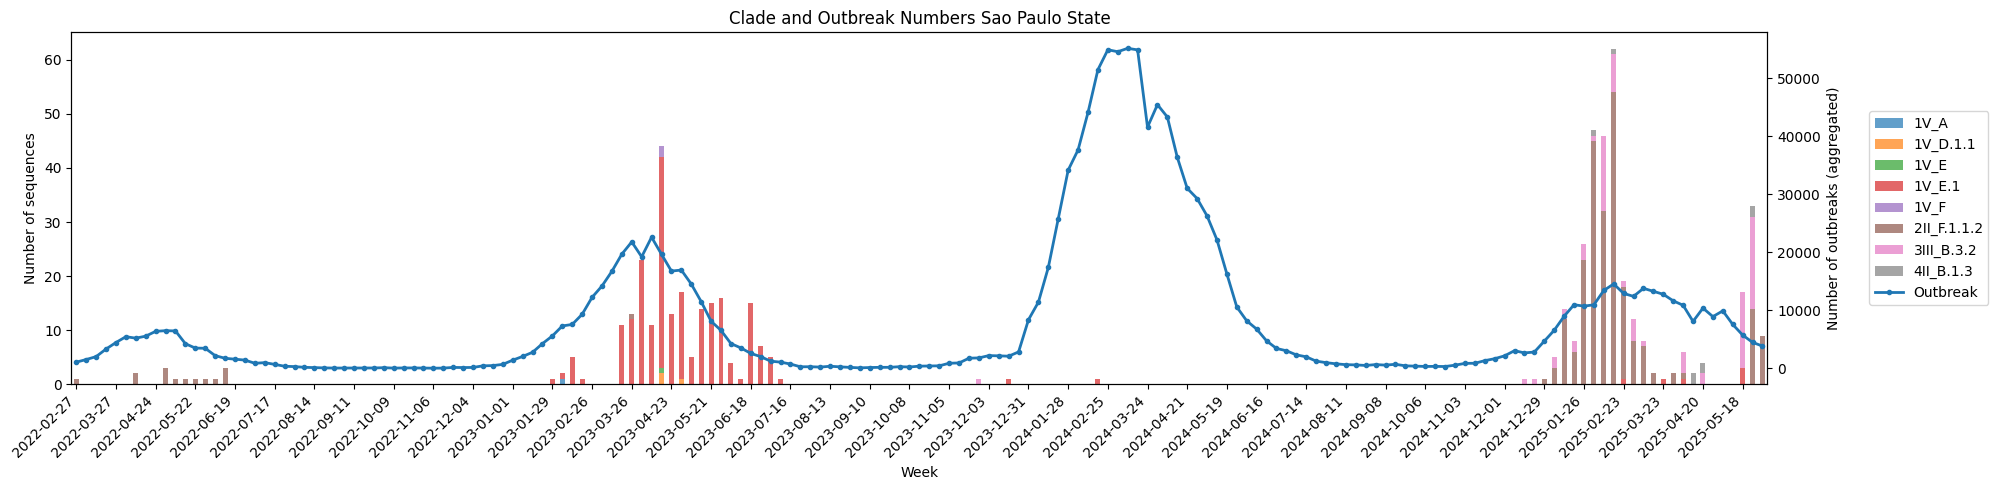

In [ ]:
# using counts
plot_clades_otb(wide_week_full, wide_mem,
                        value_col="outbreak",
                        location_label="Minas Gerais State")

## Make interpolation for short gaps
If there are short gaps of 1 - 3 weeks where no clades data exists, fill the gaps via linear interpolation

In [ ]:
def intp(df, max_gap=3):

    out = df.copy()
    zero = (out.sum(axis=1) == 0)
    grp = (zero != zero.shift(fill_value=False)).cumsum()
    run_len = zero.groupby(grp).transform("sum")
    mask = zero & (run_len <= max_gap)

    out[mask] = np.nan
    out = out.interpolate(axis=0)

    return out

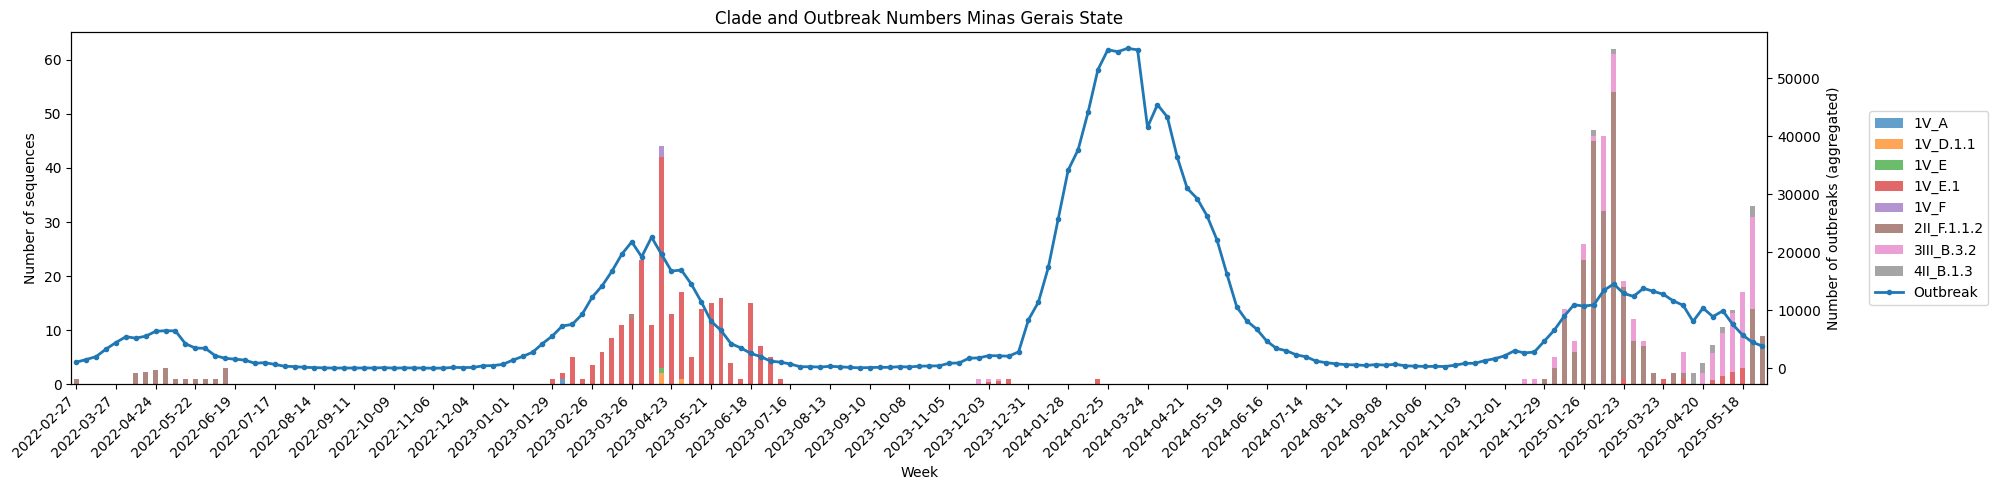

In [ ]:
# using counts
w_intp = intp(wide_week_full)
plot_clades_otb(w_intp, wide_mem,
                        value_col="outbreak",
                        location_label="Minas Gerais State")

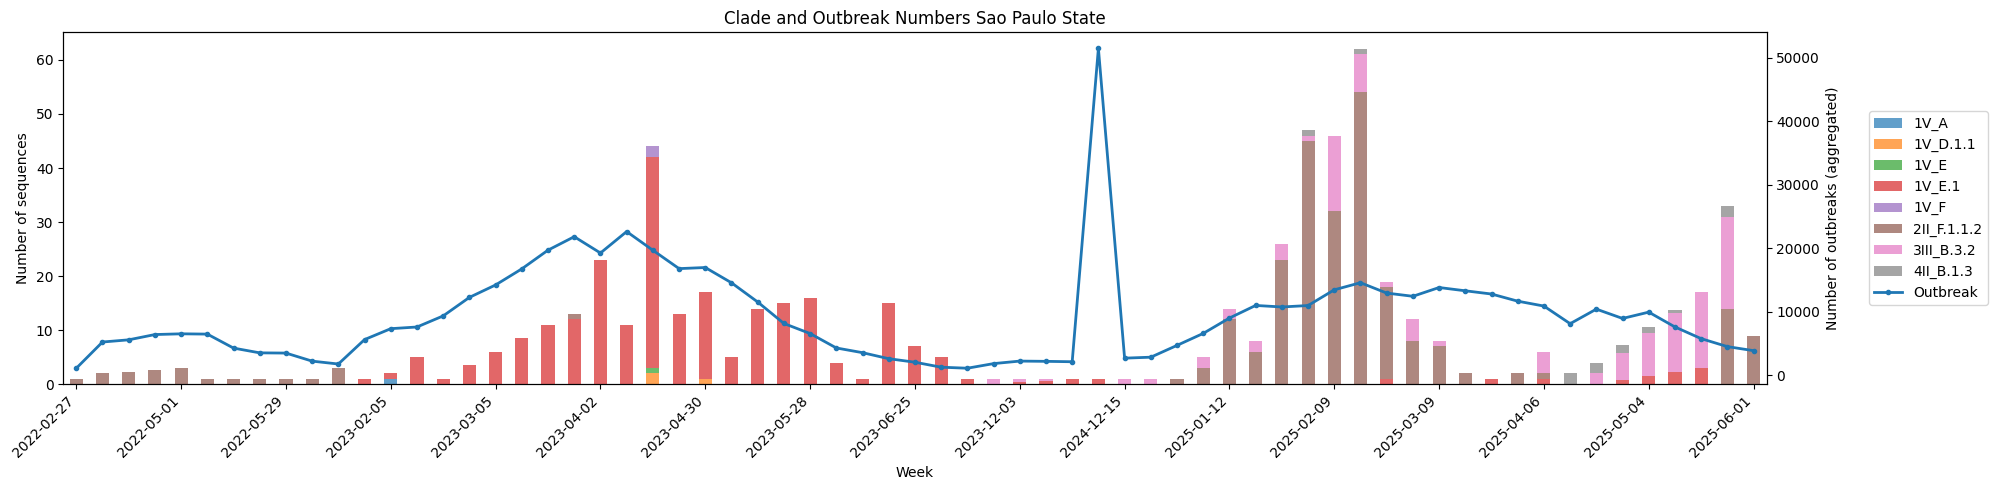

In [ ]:
mask = w_intp.sum(axis=1) > 0
w_intp2 = w_intp[mask].copy()

# using counts
plot_clades_otb(w_intp2, wide_mem,
                        value_col="outbreak",
                        location_label="Sao Paulo State")

## Take percentage proportion and find the expected clade counts from MEM output

In [ ]:
w_intp_perc = w_intp.div(w_intp.sum(axis=1), axis=0)

# Drop the rows with no clade info
mask = w_intp_perc.sum(axis=1) > 0
w_intp_perc = w_intp_perc[mask].copy()

w_intp_perc.columns.name = None
w_intp_perc = w_intp_perc.reset_index().rename(columns={"week": "Date"})

w_intp_perc.head(3)

,Date,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2II_F.1.1.2,3III_B.3.2,4II_B.1.3
0,2022-02-27,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2022-04-10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2022-04-17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# make sure dates are datetime
wide_mem2 = wide_mem.rename(columns={"data_iniSE": "Date"})
wide_mem2["Date"] = pd.to_datetime(wide_mem2["Date"])

# inner join = only dates present in both tables
merged = pd.merge(w_intp_perc, wide_mem2, on="Date", how="inner")
merged.iloc[:, 1:-2] = merged.iloc[:, 1:-2].mul(merged["outbreak"], axis=0)
merged

,Date,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2II_F.1.1.2,3III_B.3.2,4II_B.1.3,endemic,outbreak
0,2022-02-27,0.0,0.0,0.0,0.000000,0.0,1085.688545,0.000000,0.000000,471.670570,1085.688545
1,2022-04-10,0.0,0.0,0.0,0.000000,0.0,5218.516947,0.000000,0.000000,415.821621,5218.516947
2,2022-04-17,0.0,0.0,0.0,0.000000,0.0,5563.994183,0.000000,0.000000,508.290495,5563.994183
3,2022-04-24,0.0,0.0,0.0,0.000000,0.0,6394.318821,0.000000,0.000000,493.545476,6394.318821
4,2022-05-01,0.0,0.0,0.0,0.000000,0.0,6510.076431,0.000000,0.000000,413.817299,6510.076431
...,...,...,...,...,...,...,...,...,...,...,...
60,2025-05-04,0.0,0.0,0.0,1417.754575,0.0,0.000000,7561.357732,945.169717,292.012775,9924.282024
61,2025-05-11,0.0,0.0,0.0,1241.795853,0.0,0.000000,6071.001947,275.954634,253.306486,7588.752434
62,2025-05-18,0.0,0.0,0.0,1014.678093,0.0,0.000000,4735.164436,0.000000,278.110709,5749.842529
63,2025-05-25,0.0,0.0,0.0,0.000000,0.0,1906.684093,2315.259255,272.383442,349.632875,4494.326790


In [ ]:
save_path = "/content/drive/MyDrive/GISAID/cases_MG.csv"

merged.to_csv(save_path, index=False)
print("Saved", save_path)

Saved /content/drive/MyDrive/GISAID/cases_MG.csv


## Import Dengue Data

In [ ]:
def data_donwload(geocode, y_start, y_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = geocode
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = y_start
  ey_end = y_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])

  dados = pd.read_csv(url_resp, index_col='SE')
  dados['ibge'] = geocode
  return dados

In [ ]:
downdload_data = False # Manual switch to download data
if downdload_data == True:
  all_data = []
  y_start= 2021
  y_end = 2025
  for geocode in tqdm(codes_sp, desc="Downloading"):
      try:
          df = data_donwload(geocode, y_start=y_start, y_end=y_end)
          df['ibge'] = geocode
          all_data.append(df)
      except Exception as e:
          print(f"Failed for {geocode}: {e}")
      time.sleep(0.1)

  data_mg = pd.concat(all_data)
  data_mg.head()

  del all_data
  gc.collect()

  # Save in my drive so i don't need to redownload
  data_mg2 = data_mg[['data_iniSE', 'ibge', 'nivel', 'casos', 'pop']]
  save_path = "/content/drive/MyDrive/GISAID/data_mg_incidence.csv"
  data_mg2.to_csv(save_path, index=False)
  print(f"File saved to: {save_path}")

else:
  data_mg2 = pd.read_csv('/content/drive/MyDrive/GISAID/data_mg_incidence.csv')
  data_mg2 = data_mg2[['data_iniSE', 'ibge', 'nivel', 'casos', 'pop']]

data_mg2.head(5)

,data_iniSE,ibge,nivel,casos,pop
0,2025-09-21,3100104,1,0,6235.0
1,2025-09-14,3100104,1,0,6235.0
2,2025-09-07,3100104,1,0,6235.0
3,2025-08-31,3100104,1,0,6235.0
4,2025-08-24,3100104,1,0,6235.0


In [ ]:
data_mg2['nivel'].unique()

array([1, 2, 4, 3])

In [ ]:
# Take the municipality that is on the sero data
ibge_mg_target = sero1_ibge['IBGE'].unique()

ibge_int = (pd.to_numeric(pd.Series(ibge_mg_target), errors='coerce')
              .dropna()
              .astype(int)
              .to_numpy())
len(ibge_int)

77

In [ ]:
inc_mg = data_mg2[data_mg2['ibge'].isin(ibge_int)]
inc_mg.tail()

,data_iniSE,ibge,nivel,casos,pop
207972,2021-01-31,3171204,2,1,129765.0
207973,2021-01-24,3171204,2,1,129765.0
207974,2021-01-17,3171204,2,3,129765.0
207975,2021-01-10,3171204,1,3,129765.0
207976,2021-01-03,3171204,1,1,129765.0


In [ ]:
print("the data starts from",inc_mg['data_iniSE'].min(), 'to', inc_mg['data_iniSE'].max())

the data starts from 2021-01-03 to 2025-09-21


In [ ]:
# Take the data from 2022-01 and 2025-07
inc_mg = inc_mg[(inc_mg['data_iniSE'] >= '2022-01-01') & (inc_mg['data_iniSE'] < '2025-08-01')]
print("the data starts from",inc_mg['data_iniSE'].min(), 'to', inc_mg['data_iniSE'].max())
inc_mg.tail()

the data starts from 2022-01-02 to 2025-07-27


,data_iniSE,ibge,nivel,casos,pop
207920,2022-01-30,3171204,1,0,129765.0
207921,2022-01-23,3171204,2,4,129765.0
207922,2022-01-16,3171204,2,2,129765.0
207923,2022-01-09,3171204,1,4,129765.0
207924,2022-01-02,3171204,1,2,129765.0


In [ ]:
# ## to optimize later
# save_path = "/content/drive/MyDrive/GISAID/data_mg_incidence_target.csv"
# inc_mg.to_csv(save_path, index=False)
# print(f"File saved to: {save_path}")

### Aggregate Info Dengue

In [ ]:
# # Simple method
# inc_mg = inc_mg.copy()
# inc_mg['month'] = pd.to_datetime(inc_mg['data_iniSE']).values.astype('datetime64[M]')

# inc_mg = inc_mg.copy()

# inc_mg['nivel2'] = inc_mg['nivel'].astype('object')

# m1 = (inc_mg['nivel'] == 1) & (inc_mg['casos'] == 0)   # green & zero cases
# m2 = (inc_mg['nivel'] == 1) & (inc_mg['casos']  > 0)   # green & some cases

# inc_mg.loc[m1, 'nivel2'] = 'non_case'
# inc_mg.loc[m2, 'nivel2'] = 'endemic'

# nivel_c = (inc_mg.groupby(['month','nivel2'], as_index=False)
#                  .size()
#                  .rename(columns={'size':'n_rows'}))

# nivel_cw = nivel_c.pivot(index='month', columns='nivel2', values='n_rows').fillna(0).astype(int)
# nivel_cw['alarm'] = nivel_cw[2]+ nivel_cw[3]+nivel_cw[4] # Combine the 2,3,4 alert level into just 'alarm'
# nivel_cw.drop(columns=[2,3,4], inplace=True)

# nivel_cw = nivel_cw.copy()
# nivel_cw.index = pd.to_datetime(nivel_cw.index)

# # Convert to percentage
# nivel_perc = nivel_cw.div(nivel_cw.sum(axis=1), axis=0).mul(100)
# nivel_perc.tail(3)

In [ ]:
inc_mg = mem_res.copy()
inc_mg['data_iniSE'] = pd.to_datetime(inc_mg['data_iniSE'])

inc_mg['nivel2'] = inc_mg['nivel'].astype('object')

m1 = (inc_mg['nivel'] == 1) & (inc_mg['rate_pop'] == 0)   # green & zero cases
m2 = (inc_mg['nivel'] == 1) & (inc_mg['rate_pop']  > 0)   # green & some cases

inc_mg.loc[m1, 'nivel2'] = 'non_case'
inc_mg.loc[m2, 'nivel2'] = 'endemic'

# --- group by WEEK (data_iniSE) instead of month ---
nivel_c = (inc_mg.groupby(['data_iniSE', 'nivel2'], as_index=False)
                 .size()
                 .rename(columns={'size': 'n_rows'}))

nivel_cw = (nivel_c
            .pivot(index='data_iniSE', columns='nivel2', values='n_rows')
            .fillna(0)
            .astype(int))

# Combine 2,3,4 into 'alarm' as before
nivel_cw['alarm'] = nivel_cw[2] + nivel_cw[3] + nivel_cw[4]
nivel_cw.drop(columns=[2, 3, 4], inplace=True)

nivel_cw = nivel_cw.copy()
nivel_cw.index = pd.to_datetime(nivel_cw.index)

# Convert to percentage (still weekly now)
nivel_perc = nivel_cw.div(nivel_cw.sum(axis=1), axis=0)
nivel_perc.tail(3)


nivel2,endemic,non_case,alarm
data_iniSE,,,
2025-11-09,0.259740,0.168831,0.571429
2025-11-16,0.155844,0.272727,0.571429
2025-11-23,0.090909,0.363636,0.545455


In [ ]:
nivel_perc.head(3)

nivel2,endemic,non_case,alarm
data_iniSE,,,
2022-01-02,0.402597,0.324675,0.272727
2022-01-09,0.324675,0.246753,0.428571
2022-01-16,0.168831,0.207792,0.623377


In [ ]:
## Recheck if the sum is 100
row_sums = nivel_perc.sum(axis=1, skipna=True)
ok = np.isclose(row_sums.to_numpy(), 100.0, atol=1e-6)
ok_all = bool(np.all(ok))
ok_all

False

In [ ]:
# nivel_perc_plot = nivel_perc.copy()
# nivel_perc_plot.columns = nivel_perc_plot.columns.map(str)
# nivel_perc_plot['month'] = nivel_perc_plot.index
# df_long = nivel_perc_plot.melt(id_vars='month', var_name='nivel', value_name='percent')

# fig = px.area(
#     df_long,
#     x='month', y='percent', color='nivel',
#     category_orders={'nivel': ['endemic','non_case','2','3','4']},
#     labels={'percent':'Proportion (%)', 'month':'Month', 'nivel':'nivel'},
#     # title='Monthly proportion of the labels'
# )

# fig.update_layout(
#     template='plotly_white',
#     hovermode='x unified',

#     # title=dict(text='Monthly proportion of the labels', font=dict(size=28)),
#     # font=dict(size=16),
#     legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0,
#                 title_text='nivel', font=dict(size=18)),
#     hoverlabel=dict(font_size=14))


# fig.update_xaxes(title_text='Month',
#                  title_font=dict(size=20),
#                  tickfont=dict(size=18))
# fig.update_yaxes(title_text='Proportion (%)',
#                  title_font=dict(size=20),
#                  tickfont=dict(size=18),
#                  range=[0,100], ticksuffix='%')

# fig.show()



## Import the Epi-Quark

In [ ]:
try:
    from epiquark import conf_matrix, score, timeliness
except ImportError:
    import sys
    !{sys.executable} -m pip install git+https://github.com/aauss/epi-quark.git
    from epiquark import conf_matrix, score, timeliness

Reformat the cases data

In [ ]:
merged2 = merged.drop(columns="outbreak")
mm = merged2.melt(
    id_vars="Date",
    var_name="data_label",
    value_name="value"
)
mm = mm.sort_values(by='Date', ascending=True).reset_index(drop=True)
mm.head(11)

,Date,data_label,value
0,2022-02-27,1V_A,0.000000
1,2022-02-27,endemic,471.670570
2,2022-02-27,1V_D.1.1,0.000000
3,2022-02-27,2II_F.1.1.2,1085.688545
4,2022-02-27,1V_F,0.000000
5,2022-02-27,1V_E,0.000000
6,2022-02-27,4II_B.1.3,0.000000
7,2022-02-27,1V_E.1,0.000000
8,2022-02-27,3III_B.3.2,0.000000
9,2022-04-10,endemic,415.821621


Reformat the signal data

In [ ]:
nivel_perc.columns.name = None
nivel_perc2 = nivel_perc.reset_index().rename(columns={"data_iniSE": "Date"})
nivel_perc2 = nivel_perc2[nivel_perc2['Date'].isin(merged['Date'].unique())]
nivel_perc2.head(3)

,Date,endemic,non_case,alarm
8,2022-02-27,0.324675,0.194805,0.480519
14,2022-04-10,0.155844,0.103896,0.740260
15,2022-04-17,0.519481,0.077922,0.402597


In [ ]:
nn = nivel_perc2.melt(
    id_vars="Date",
    var_name="signal_label",
    value_name="value"
)
nn

,Date,signal_label,value
0,2022-02-27,endemic,0.324675
1,2022-04-10,endemic,0.155844
2,2022-04-17,endemic,0.519481
3,2022-04-24,endemic,0.532468
4,2022-05-01,endemic,0.415584
...,...,...,...
190,2025-05-04,alarm,0.610390
191,2025-05-11,alarm,0.610390
192,2025-05-18,alarm,0.532468
193,2025-05-25,alarm,0.441558


In [ ]:
len(mem_res['ibge'].unique())

77

**Epi-Quark**

In [ ]:
cases = mm
cases["value"] = cases["value"].round().astype(int)
cases = cases[~cases["data_label"].isin(["1V_F", "4II_B.1.3", "1V_E", '1V_A', '2III_C.1.1', '1V_D.1.1'])].copy()
cases = (
    cases
    .sort_values(["Date", "data_label"])  # first by x1, then by data_label
    .reset_index(drop=True)             # new 0..N-1 index
)

signals = nn
dl = cases['data_label'].unique()
disease_list = np.concatenate([dl, ['non_case']])

In [ ]:
# print('Recheck that time steps are complete:', np.all(cases['Date'].unique()==signals['Date'].unique()))

In [ ]:
metrics_epi_quark = {
    "precision": score(cases, signals, "precision", 0.25, 0.25),
    "recall": score(cases, signals, "recall", 0.25, 0.25),
    "f1": score(cases, signals, "f1", 0.25, 0.25),
    # "r2": score(cases, signals, "r2")
}

epi_quark_df = pd.DataFrame(metrics_epi_quark, index=disease_list)
epi_quark_df = epi_quark_df.round(2)
epi_quark_df

/usr/local/lib/python3.12/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)

## Manual Evaluation

For Cases:

Calculate the $P(d|x)$

In layman terms, the percentage of finding clade type 1VA/1V_D.1.1/.../endemic in each time step.


In [ ]:
cases_numw = merged.drop(columns =["outbreak"])

dates = cases_numw['Date']
num = cases_numw.drop(columns=['Date'])
num = num.div(num.sum(axis=1), axis=0)

cases_perc = num.copy()
cases_perc['date'] = dates
cases_perc['non_case'] = 0
cases_perc.head(3)

,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2II_F.1.1.2,3III_B.3.2,4II_B.1.3,endemic,date,non_case
0,0.0,0.0,0.0,0.0,0.0,0.697134,0.0,0.0,0.302866,2022-02-27,0
1,0.0,0.0,0.0,0.0,0.0,0.926199,0.0,0.0,0.073801,2022-04-10,0
2,0.0,0.0,0.0,0.0,0.0,0.916293,0.0,0.0,0.083707,2022-04-17,0


In [ ]:
# ## Take the big 3 and the other are clumps as other
# cc = ['1V_E.1', '2II_F.1.1.2', '3III_B.3.2']
# cases_perc = cases_perc[cc + ['endemic', 'non_case', 'date']]
# # cases_perc = cases_perc["value"].round().astype(int)
# cases_perc.head(3)

In [ ]:
# big 3 clades
cc = ['1V_E.1', '2II_F.1.1.2', '3III_B.3.2']

# all the "other" clades = all clades except the big 3
other_cols = [c for c in cases_perc.columns if c not in cc + ['endemic', 'non_case', 'date']]

# # aggregate the other clades
cases_perc['other'] = cases_perc[other_cols].sum(axis=1)
cases_perc = cases_perc[cc + ['other', 'endemic', 'non_case', 'date']]
cases_perc.head(3)

,1V_E.1,2II_F.1.1.2,3III_B.3.2,other,endemic,non_case,date
0,0.0,0.697134,0.0,0.0,0.302866,0,2022-02-27
1,0.0,0.926199,0.0,0.0,0.073801,0,2022-04-10
2,0.0,0.916293,0.0,0.0,0.083707,0,2022-04-17


For Signals (part 1):

First compute $w(s,x)$, the weight of signal $s$ in cell $x$.
In general, $w(s,x)$ can be any measure of signal strength (e.g. a significance value, p-value, or other weight).
In this case, $x$ is a state-month, and $w(s,x)$ is defined as the percentage of occurrences of signal $s$ among all signal labels (outbreak, endemic, non_case) across all municipality-week cells within that state and month.

One then compute $p(s|x)$, the probability of observing signal $s$ in cell $x$, as $p(s|x) = \frac{w(s,x)}{\sum_{s'} w(s',x)}$
Because the $w(s,x)$ values are already normalized to sum to $1$ over all signals, in this specific case one has simply $p(s|x) = w(s,x)$


In [ ]:
nivel_perc2.head(3)

,Date,endemic,non_case,alarm
8,2022-02-27,0.324675,0.194805,0.480519
14,2022-04-10,0.155844,0.103896,0.740260
15,2022-04-17,0.519481,0.077922,0.402597


For Signals (part 2):

Define the $p(d|s)$ or in layman terms "If the algorithm gives signal $s$, how can one associate it with cases label $d$?"

The certain rules are as follows:

1. For non_case

$p(d = non-case | s = non-case) = 1$,

$p(d \neq non-case | s = non-case) = 0$

2. For endemic

$p(d = endemic | s = endemic) = 1$,

$p(d \neq endemic | s = endemic) = 0$

3. For outbreak with endemic and non-case

$p(d = non-case | s = outbreak) = 0$,

$p(d = endemic | s = outbreak) = 0$



Assuming uniform probability, i.e. where if one see a signal it has uniform probability being associated with any clade labels.

$p(d = clade-k | s = outbreak) = 1/K$,

where K is number of clades


In [ ]:
# pds_co = 1/len(clade_counts)
pds_co = 1/3
pds_co

0.3333333333333333

For Signals (part 3):

Compute $\hat{p}(d|x) = \sum_s{p(d|s)p(s|x)}$

Because I have only 1 outbreak, therefore it is simplified to
$\hat{p}(d = clade_k | x) = \frac{1}{K}p(s = outbreak | x)$

In [ ]:
clades_class = cc + ['other']
clades_class

['1V_E.1', '2II_F.1.1.2', '3III_B.3.2', 'other']

In [ ]:
phat_dx = nivel_perc2.copy()

new_cols = {
    clade: phat_dx['alarm'] * pds_co
    # for clade in clade_counts['clade']
    for clade in clades_class
}

phat_dx = phat_dx.assign(**new_cols)
phat_dx = phat_dx.drop(columns=['alarm'])

phat_dx.head()

,Date,endemic,non_case,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
8,2022-02-27,0.324675,0.194805,0.160173,0.160173,0.160173,0.160173
14,2022-04-10,0.155844,0.103896,0.246753,0.246753,0.246753,0.246753
15,2022-04-17,0.519481,0.077922,0.134199,0.134199,0.134199,0.134199
16,2022-04-24,0.532468,0.012987,0.151515,0.151515,0.151515,0.151515
17,2022-05-01,0.415584,0.077922,0.168831,0.168831,0.168831,0.168831


Evaluation

In [ ]:
## Make sure the dates matches
all(cases_perc['date'].values == phat_dx['Date'].values)

True

In [ ]:
len(cases_perc) == len(phat_dx)

True

In [ ]:
clade_cols = [c for c in cases_perc.columns if c not in ['date']]

cases_sorted = cases_perc.sort_values('date').reset_index(drop=True)
phat_sorted  = phat_dx.sort_values('Date').reset_index(drop=True)

threshold = 0.25

results = []

for clade in clade_cols:

    p_true = cases_sorted[clade]
    p_hat  = phat_sorted[clade]

    # Turn into binary based on the threshold
    y_true = (p_true >= threshold).astype(int)
    y_pred = (p_hat  >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    results.append({
        'clade': clade,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

clade_scores = pd.DataFrame(results)
clade_scores

,clade,precision,recall,f1
0,1V_E.1,0.486486,0.620690,0.545455
1,2II_F.1.1.2,0.351351,0.500000,0.412698
2,3III_B.3.2,0.216216,0.571429,0.313725
3,other,0.081081,1.000000,0.150000
4,endemic,0.090909,0.666667,0.160000
5,non_case,0.000000,0.000000,0.000000


## Manual Evaluation Clade vs Farrington Flexible (Figurative Purpose)

In [ ]:
ff = pd.read_csv('/content/drive/MyDrive/Mosquito_Data/dengue_spaulo_all.csv')
ff = ff[ff['Week'] >= '2022-01-16'].reset_index(drop=True)
ff.head(5)

,Week,Reported_Cases,Farrington_Flexible,Farrington_Flexible_pval
0,2022-01-16,7313.569353,0,0.294839
1,2022-01-23,7996.680551,0,0.278863
2,2022-01-30,8638.988440,0,0.329443
3,2022-02-06,9376.965023,0,0.317422
4,2022-02-13,10543.559735,0,0.482298


In [ ]:
ff_wide = (
    ff.assign(
        endemic = ff['Farrington_Flexible_pval'],
        alarm   = 1 - ff['Farrington_Flexible_pval']
    )[["Week", "endemic", "alarm"]]
)
ff_wide['non_case'] = 0
ff_wide = ff_wide.rename(columns={'Week': 'Date'})

ff_wide.head()

,Date,endemic,alarm,non_case
0,2022-01-16,0.294839,0.705161,0
1,2022-01-23,0.278863,0.721137,0
2,2022-01-30,0.329443,0.670557,0
3,2022-02-06,0.317422,0.682578,0
4,2022-02-13,0.482298,0.517702,0


In [ ]:
phat_dx2 = ff_wide.copy()

new_cols = {
    clade: phat_dx2['alarm'] * pds_co
    # for clade in clade_counts['clade']
    for clade in clades_class
}

phat_dx2 = phat_dx2.assign(**new_cols)
phat_dx2 = phat_dx2.drop(columns=['alarm'])

phat_dx2.head()

,Date,endemic,non_case,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-01-16,0.294839,0,0.235054,0.235054,0.235054,0.235054
1,2022-01-23,0.278863,0,0.240379,0.240379,0.240379,0.240379
2,2022-01-30,0.329443,0,0.223519,0.223519,0.223519,0.223519
3,2022-02-06,0.317422,0,0.227526,0.227526,0.227526,0.227526
4,2022-02-13,0.482298,0,0.172567,0.172567,0.172567,0.172567


In [ ]:
valid_dates = pd.to_datetime(cases_perc['date'].dt.date.unique())
phat_dx2['Date']   = pd.to_datetime(phat_dx2['Date'])

# keep only rows whose Date appears in cases_perc['date']
phat_dx22 = phat_dx2[phat_dx2['Date'].isin(valid_dates)]
phat_dx22

,Date,endemic,non_case,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
6,2022-02-27,0.422055,0,0.192648,0.192648,0.192648,0.192648
12,2022-04-10,0.309308,0,0.230231,0.230231,0.230231,0.230231
13,2022-04-17,0.433322,0,0.188893,0.188893,0.188893,0.188893
14,2022-04-24,0.230663,0,0.256446,0.256446,0.256446,0.256446
15,2022-05-01,0.034460,0,0.321847,0.321847,0.321847,0.321847
...,...,...,...,...,...,...,...
172,2025-05-04,0.633330,0,0.122223,0.122223,0.122223,0.122223
173,2025-05-11,0.602584,0,0.132472,0.132472,0.132472,0.132472
174,2025-05-18,0.559035,0,0.146988,0.146988,0.146988,0.146988
175,2025-05-25,0.663750,0,0.112083,0.112083,0.112083,0.112083


In [ ]:
## Make sure the dates matches
all(cases_perc['date'].values == phat_dx22['Date'].values)

True

In [ ]:
len(cases_perc) == len(phat_dx)

True

In [ ]:
clade_cols = [c for c in cases_perc.columns if c not in ['date']]

cases_sorted = cases_perc.sort_values('date').reset_index(drop=True)
phat_sorted  = phat_dx22.sort_values('Date').reset_index(drop=True)

threshold = 0.25

results = []

for clade in clade_cols:

    p_true = cases_sorted[clade]
    p_hat  = phat_sorted[clade]

    # Turn into binary based on the threshold
    y_true = (p_true >= threshold).astype(int)
    y_pred = (p_hat  >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    results.append({
        'clade': clade,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

clade_scores = pd.DataFrame(results)
clade_scores

,clade,precision,recall,f1
0,1V_E.1,0.428571,0.206897,0.279070
1,2II_F.1.1.2,0.571429,0.307692,0.400000
2,3III_B.3.2,0.071429,0.071429,0.071429
3,other,0.000000,0.000000,0.000000
4,endemic,0.039216,0.666667,0.074074
5,non_case,0.000000,0.000000,0.000000
